# 03 - Logistic Regression
Prepared by Jan Christian Blaise Cruz

DLSU Machine Learning Group

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation

We'll load the Wisconsin Breast Cancer dataset for use in classification. To better visualize logistic regression, we will only use two features: mean radius of the tumor, and mean concavity of the tumor.

We'll explicitly add a bias feature using an array of ones.

In [ ]:
data = load_breast_cancer()

# Mean radius and the mean concavity
x = data.data[:, [0, 6]]
y = data.target

biases = np.ones((len(x), 1))
x = np.concatenate([x, biases], axis=1)

c1 = x[y == 0] # malignant
c2 = x[y == 1] # benign

We can check that the dataset has three features and 569 samples. We have 212 malignant tumors and 357 benign ones.

In [ ]:
x.shape, y.shape, c1.shape, c2.shape

((569, 3), (569,), (212, 3), (357, 3))

Let's plot this out.

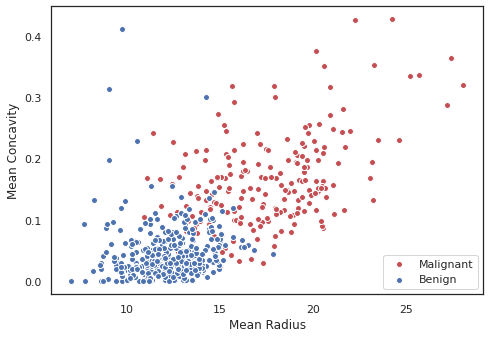

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(c1[:, 0], c1[:, 1], color='r', cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
ax.scatter(c2[:, 0], c2[:, 1], color='b', cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

ax.set_xlabel("Mean Radius")
ax.set_ylabel("Mean Concavity")
ax.legend(["Malignant", "Benign"])
plt.show()

We will split the data to training and testing sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(X_train.shape, X_test.shape)

(426, 3) (143, 3)


# Logistic Regression

Recall our hypothesis:
$$h_\theta(x) = \sigma(\theta^T X)$$
Where $\sigma$ is the sigmoid function:
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
This model outputs a value between 0 and 1 that can be interpreted as the probability that a certain tumor is benign (y = 1).

Let's produce the sigmoid function.

In [ ]:
def sigmoid(x):
    return 1.0 / (1 + np.e ** -x)

Let's plot the graph of the function.

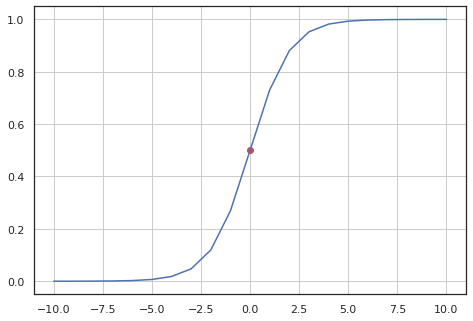

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(-10, 11), sigmoid(np.arange(-10, 11)))
ax.scatter(0, 0.5, color='r')
ax.grid()
plt.show()

To produce the model, we need to initialize our $\theta$ parameters. We'll have three parameters since we have three features.

In [ ]:
np.random.seed(42)
theta = np.random.rand(3, 1)

print(theta)

[[0.37454012]
 [0.95071431]
 [0.73199394]]


We code up out model.

In [ ]:
def model(x, theta):
    z = x.dot(theta)
    h = sigmoid(z)
    return h

We can use this to produce probabilities given the features.

In [ ]:
yhat = model(X_train, theta)

To interpret these probabilities, we use:

$$
  y =
  \begin{cases}
  1 , h_\theta (x) \ge 0.5 \\
  0 , h_\theta (x) \lt 0.5
  \end{cases}
$$

Once we have predictions with labels 1 and 0, we can compute an accuracy score.

In [ ]:
def accuracy(yhat, yacc):
    preds = ((yhat >= 0.5) * 1).reshape(-1)
    matches = (preds == yacc) * 1
    acc = np.sum(matches) / len(yacc)
    return acc

Let's test the initial accuracy of our model given our initial theta values.

In [ ]:
print("Initial accuracy: {:.2f}%".format(accuracy(yhat, y_train) * 100))

Initial accuracy: 62.91%


Now we code up our loss function, called cross entropy.

$$
\begin{aligned}
  J(\theta) =
  \begin{cases}
  -log(h_\theta(x^{(i)}) , &y = 1 \\
  -log(1 - h_\theta(x^{(i)}) , &y = 0
  \end{cases}
\end{aligned}
$$

Collapsing this piecewise function gives us:

$$
J(\theta) = -\frac{1}{m}\sum_{i=0}^{m}[y^{(i)}log(h_\theta(x^{(i)}) + (1 - y^{(i)})log(1 - h_\theta(x^{(i)})]
$$

In vector notation this is:
$$
J(\theta) = \frac{1}{m} \cdot [-y^Tlog(h) - (1-y)^Tlog(1-h)]
$$

We'll add in a small "epsilon" value of 1e-18 inside the log function to prevent log(0) as underflow is a possbility while training.

In [ ]:
def loss_function(x, y, theta):
    yhat = model(x, theta)
    c1_loss = -y.reshape(-1, 1) * np.log(yhat + 1e-18)
    c2_loss = y.reshape(-1, 1) * np.log(1 - yhat + 1e-18)
    loss = c1_loss - c2_loss
    loss = loss.sum() / len(y)
    return loss

Let's check the loss of the initial theta parameters.

In [ ]:
print("Initial loss: {:.4f}".format(loss_function(X_train, y_train, theta)))

Initial loss: 3.3675


We'll code up gradient descent. As usual this is (repeating until convergence for all parameters $j$):
$$
\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta)
$$

Working out the partial derivative term gives us:

$$
\theta_j := \theta_j - \alpha\frac{1}{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j
$$

In vector notation:

$$
\theta = \theta - \alpha \cdot X^T(\hat{y} - y)
$$

In [ ]:
def gradient_descent(x, y, theta, lr):
    yhat = model(x, theta)
    gradient = x.T.dot((yhat - y.reshape(-1, 1))) / len(x)
    return theta - lr * gradient

Let's reinitialize theta parameters.

In [ ]:
np.random.seed(42)
theta = np.random.rand(3, 1)

print(theta)

[[0.37454012]
 [0.95071431]
 [0.73199394]]


Then run 200 epochs of gradient descent.

In [ ]:
lr = 0.001
epochs = 200

for i in range(1, epochs + 1):
    theta = gradient_descent(X_train, y_train, theta, lr)
    
    loss = loss_function(x, y, theta)
    yhat = model(X_train, theta)
    acc = accuracy(yhat, y_train)

    if i % 10 == 0 or i == 1:
        print("[{:4}/{}] Loss: {:7.4f} | Accuracy: {:.2f}%".format(i, epochs, loss, acc * 100))

[   1/200] Loss:  3.3002 | Accuracy: 62.91%
[  10/200] Loss:  2.8675 | Accuracy: 62.91%
[  20/200] Loss:  2.4003 | Accuracy: 62.91%
[  30/200] Loss:  1.9614 | Accuracy: 62.91%
[  40/200] Loss:  1.5757 | Accuracy: 62.91%
[  50/200] Loss:  1.2752 | Accuracy: 62.91%
[  60/200] Loss:  1.0793 | Accuracy: 62.91%
[  70/200] Loss:  0.9739 | Accuracy: 62.91%
[  80/200] Loss:  0.9241 | Accuracy: 62.91%
[  90/200] Loss:  0.9015 | Accuracy: 62.91%
[ 100/200] Loss:  0.8911 | Accuracy: 62.91%
[ 110/200] Loss:  0.8860 | Accuracy: 63.62%
[ 120/200] Loss:  0.8833 | Accuracy: 65.02%
[ 130/200] Loss:  0.8819 | Accuracy: 65.96%
[ 140/200] Loss:  0.8812 | Accuracy: 66.20%
[ 150/200] Loss:  0.8807 | Accuracy: 66.43%
[ 160/200] Loss:  0.8805 | Accuracy: 66.90%
[ 170/200] Loss:  0.8804 | Accuracy: 67.84%
[ 180/200] Loss:  0.8803 | Accuracy: 68.78%
[ 190/200] Loss:  0.8803 | Accuracy: 68.78%
[ 200/200] Loss:  0.8803 | Accuracy: 69.01%


We can see the loss going down. Let's check the new theta parameters.

In [ ]:
theta

array([[-0.04261119],
       [ 0.94436749],
       [ 0.71942043]])

We can take the accuracy on the test set to see if our model learned the parameters properly.

In [ ]:
yhat = model(X_test, theta)
acc = accuracy(yhat, y_test)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 65.73%


Since we're working with 2 features, we cannot simply plot a decision boundary line. Instead, let's graph the decision boundary as a heatmap of the probability field generated by our hypothesis with respect to the theta parameters.

This will show us (in color) the learned decision boundary.

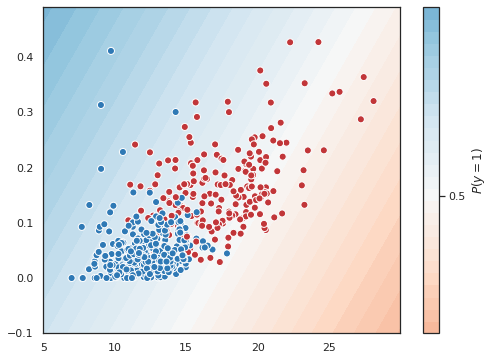

In [ ]:
# Generate Field
x1, x2 = np.mgrid[5:30:.01, -0.1:0.5:.01]
grid = np.c_[x1.ravel(), x2.ravel()]
biases = np.ones((len(grid), 1))
grid = np.concatenate([grid, biases], axis=1)
yhat = model(grid, theta).reshape(x1.shape)

# Plot Field and Scatter
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(x1, x2, yhat, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(x[:,0], x[:, 1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

Getting 65% accuracy on the test set clearly shows us that the model underfits the data. We can increase the capacity of the model by increasing the degree of the linear model. This increases variance. To offset this, we will add regularization to penalize complexity and increase bias to prevent overfitting.

# Regularized Multinomial Logistic Regression

Let's modify our data preparation to take into account the highest degree we want our model to use. Our hypothesis function will be:

$$
h_\theta(x) = \sigma(\theta_0 + \sum^{d}_{k=1}\theta_kx_1^k + \theta_kx_2^k)
$$

So, for example, for degree 3, this will be:

$$
h_\theta(x) = \sigma(\theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_1^2 + \theta_4x_2^2 + \theta_5x_1^3 + \theta_6x_2^3)
$$

We will have seven theta parameters, one for the bias, and six for each pair of features $x_1$ and $x_2$ raised to degrees 1 to 3.

For this example, we will use degree 2 to create a parabolic decision boundary.

In [ ]:
degree = 2

x = data.data[:, [0, 6]]
y = data.target

powers = [x ** i for i in range(1, degree + 1)]
biases = np.ones((len(x), 1))

tx = np.concatenate(powers, axis=1)
x = np.concatenate([tx, biases], axis=1)
features = x.shape[1]

c1 = x[y == 0] # malignant
c2 = x[y == 1] # benign

As usual we will split the data to train and test splits. We can see that our X vector has five features: bias, $x_1$ and $x_2$, and  $x_1^2$ and $x_2^2$.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(X_train.shape, X_test.shape)

(426, 5) (143, 5)


We'll rewrite our loss function to employ L2 regularization:

$$
J(\theta) = -\frac{1}{m}\sum_{i=0}^{m}[y^{(i)}log(h_\theta(x^{(i)}) + (1 - y^{(i)})log(1 - h_\theta(x^{(i)})] + \lambda\sum^{n}_{j=1}\theta^2_j
$$

In vector notation this is:
$$
J(\theta) = \frac{1}{m} \cdot [-y^Tlog(h) - (1-y)^Tlog(1-h)] + 2 \lambda \theta
$$

In [ ]:
def loss_function(x, y, theta, lamb=0.001):
    yhat = model(x, theta)
    c1_loss = -y.reshape(-1, 1) * np.log(yhat + 1e-18)
    c2_loss = y.reshape(-1, 1) * np.log(1 - yhat + 1e-18)
    loss = c1_loss - c2_loss
    loss = loss.sum() / len(y)

    regularization = lamb * 2 * (theta[:-1]).sum()

    return loss + regularization

We recode gradient descent to take into account a new regualization parameter $\lambda$.

In [ ]:
def gradient_descent(x, y, theta, lr, lamb=0.001):
    yhat = model(x, theta)
    gradient = x.T.dot((yhat - y.reshape(-1, 1)))
    gradient += lamb * theta
    gradient /= len(x)
    return theta - lr * gradient

Let's produce initial theta parameters. We will make five since we have "five features."

In [ ]:
np.random.seed(42)
theta = np.random.rand(features, 1)

print(theta)

[[0.37454012]
 [0.95071431]
 [0.73199394]
 [0.59865848]
 [0.15601864]]


Let's train for 200 epochs. Since the model has more capacity, we will use a slower learning rate to prevent overshooting.

In [ ]:
lr = 0.0001
lamb = 0.001
epochs = 200

for i in range(1, epochs + 1):
    theta = gradient_descent(X_train, y_train, theta, lr, lamb=lamb)

    loss = loss_function(x, y, theta, lamb=lamb)
    yhat = model(X_train, theta)
    acc = accuracy(yhat, y_train)

    if i % 10 == 0 or i == 1:
        print("[{:4}/{}] Loss: {:7.4f} | Accuracy: {:.2f}%".format(i, epochs, loss, acc * 100))

[   1/200] Loss: 26.0095 | Accuracy: 62.91%
[  10/200] Loss: 25.9940 | Accuracy: 62.91%
[  20/200] Loss: 25.9285 | Accuracy: 62.91%
[  30/200] Loss: 25.6244 | Accuracy: 62.91%
[  40/200] Loss: 24.1326 | Accuracy: 62.91%
[  50/200] Loss: 16.9799 | Accuracy: 62.91%
[  60/200] Loss:  5.8472 | Accuracy: 62.91%
[  70/200] Loss:  1.0034 | Accuracy: 84.98%
[  80/200] Loss:  1.0037 | Accuracy: 84.98%
[  90/200] Loss:  1.0040 | Accuracy: 84.98%
[ 100/200] Loss:  1.0043 | Accuracy: 84.98%
[ 110/200] Loss:  1.0046 | Accuracy: 84.98%
[ 120/200] Loss:  1.0049 | Accuracy: 84.98%
[ 130/200] Loss:  1.0052 | Accuracy: 84.98%
[ 140/200] Loss:  1.0055 | Accuracy: 84.98%
[ 150/200] Loss:  1.0058 | Accuracy: 84.98%
[ 160/200] Loss:  1.0061 | Accuracy: 84.98%
[ 170/200] Loss:  1.0064 | Accuracy: 84.98%
[ 180/200] Loss:  1.0067 | Accuracy: 84.98%
[ 190/200] Loss:  1.0070 | Accuracy: 84.98%
[ 200/200] Loss:  1.0073 | Accuracy: 84.98%


We can check the accuracy on the test set and see that we have achieved a better test score of around 88%.

In [ ]:
yhat = model(X_test, theta)
acc = accuracy(yhat, y_test)
print("Accuracy: {:.6f}%".format(acc * 100))

Accuracy: 88.811189%


Using the same plotting method, let's generate the probability field of the hypothesis with the learned parameters as a heatmap to see the decision boundary.

We will stretch the dimensions of the grid a little to see the parabolic nature of the decision boundary better.

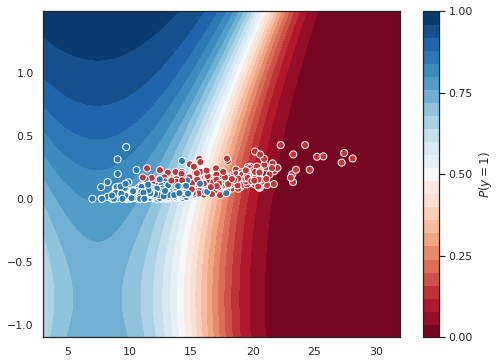

In [ ]:
# Generate Field
x1, x2 = np.mgrid[3:32:.01, -1.1:1.5:.01]
grid = np.c_[x1.ravel(), x2.ravel()]
powers = [grid ** i for i in range(1, degree + 1)]
biases = np.ones((len(grid), 1))
tx = np.concatenate(powers, axis=1)
grid = np.concatenate([tx, biases], axis=1)
yhat = model(grid, theta).reshape(x1.shape)

# Plot Field and Scatter
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(x1, x2, yhat, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(x[:,0], x[:, 1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

# Course Notes (Optional)

## Recap

Logistic Regression, our classification algorithm, is similar to Linear Regression, except that in order to interpret our outputs as a probability, we have to bound the output of the linear model between 0 and 1. 

The Sigmoid function $\sigma(x) = \frac{1}{1+e^{-x}}$ is useful for this purpose because it has y-asymptotes at 1 and 0. Formally:

$$
\begin{aligned}
\lim_{x\rightarrow\infty} \sigma(x) &= 1 \\
\lim_{x\rightarrow-\infty} \sigma(x) &= 0 
\end{aligned}
$$

When given any input $x$, $\sigma(x)$ will output a value between 0 and 1. This gives us the following hypothesis:

$$h_\theta(x) = \sigma(\theta^T X)$$

Interpreting the output of the hypothesis in simple. We use a threshold:

$$
  y =
  \begin{cases}
  1 , h_\theta (x) \ge 0.5 \\
  0 , h_\theta (x) \lt 0.5
  \end{cases}
$$

If the output of $h_\theta(x) \ge 0.5$, then our prediction is the label 1. We can think of the output of our model as a probability. Formally, we can write this as $(y = 1 | x;\theta)$, or "the probability that the label is 1 given x parametrized by theta."

---

The derivative of the sigmoid is also easy to compute for when we take the partial derivatives during gradient descent (derivation below):

$$
\sigma\prime(x) = \sigma(x)(1 - \sigma(x))
$$

We cannot use Mean Squared Error (MSE) as our loss function for logistic regression. Instead, we use Cross Entropy Loss:

$$
\begin{aligned}
  J(\theta) =
  \begin{cases}
  -log(h_\theta(x^{(i)}) , &y = 1 \\
  -log(1 - h_\theta(x^{(i)}) , &y = 0
  \end{cases}
\end{aligned}
$$

Collapsing this piecewise function gives us:

$$
J(\theta) = -\frac{1}{m}\sum_{i=0}^{m}[y^{(i)}log(h_\theta(x^{(i)}) + (1 - y^{(i)})log(1 - h_\theta(x^{(i)})]
$$

This function has two graphs (credits to Andrew Ng):

![AndrewNg](https://ml-cheatsheet.readthedocs.io/en/latest/_images/y1andy2_logistic_function.png)

The loss function penalizes "confident wrong predictions." For example, if the correct label is y = 1, but the model produces $h_\theta(x) = 0.05$ (prediction y = 0), we give this a high penalty (refer to the left graph).

We can use this loss function for gradient descent in the same way as MSE. Our update rule for gradient descent is the same:

$$
\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta)
$$

Working out the partial derivative term gives us (Derivation below):

$$
\theta_j := \theta_j - \alpha\frac{1}{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j
$$

This will then give us learned theta parameters that, together with the hypothesis, plots the best decision boundary that separates the classes we wish to classify.

## Derivations

Derivation of $\sigma\prime(x) = \sigma(x)(1 - \sigma(x))$:

$$
\begin{aligned}
\frac{d}{dx}\sigma(x) &= \frac{d}{dx}\left(\frac{1}{1+e^{-x}} \right)\\
&= \frac{d}{dx} (1 + e^{-x})^{-1} \\
&= -(1 + e^{-1})^{-2}(-e^{-x}) \\
&= -\frac{-e^{-x}}{(1 + e^{-x})^2} \\
&= \frac{1}{1 + e^{-x}}\frac{e^{-x}}{1 + e^{-x}} \\
&= \frac{1}{1 + e^{-x}}\frac{e^{-x} + 1 - 1}{1 + e^{-x}} \\
&= \frac{1}{1 + e^{-x}}\left(\frac{1 + e^{-x}}{1 + e^{-x}}-\frac{1}{1 + e^{-x}}\right) \\
&= \sigma(x)(1 - \sigma(x))
\end{aligned}
$$

Derivation of $
 \frac{\partial}{\partial\theta_j}J(\theta)= \frac{1}{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j
$:

$$
\begin{aligned}
\frac{\partial}{\partial\theta_j}J(\theta) &= \frac{\partial}{\partial\theta_j} \left[-\frac{1}{m}\sum_{i=0}^{m}[y^{(i)}log(h_\theta(x^{(i)}) + (1 - y^{(i)})log(1 - h_\theta(x^{(i)})]\right] \\
&= \frac{\partial}{\partial\theta_j} \left[-\frac{1}{m}\sum_{i=0}^{m}[y_ilog(\hat{y}_i) + (1 - y_i)log(1 - \hat{y}_i)]\right] &(1) \\
&= -\frac{1}{m}\sum_{i=0}^{m}\left[y_i  \frac{\partial}{\partial\theta_j} log(\hat{y}_i) + (1 - y_i)  \frac{\partial}{\partial\theta_j} log(1 - \hat{y}_i)\right] &(2) \\
&= -\frac{1}{m}\sum_{i=0}^{m}\left[y_i \frac{\hat{y}_i(1 - \hat{y}_i)x^i_j}{\hat{y}_i} - (1 - y_i) \frac{\hat{y}_i(1 - \hat{y}_i)x^i_j}{(1 - \hat{y}_i)}\right] &(3) \\
&= -\frac{1}{m}\sum_{i=0}^{m}[y_i (1 - \hat{y}_i) - (1 - y_i) \hat{y}_i ] x^i_j &(4) \\
&= -\frac{1}{m}\sum_{i=0}^{m}(y_i - y_i\hat{y}_i -\hat{y}_i + y_i\hat{y}_i ) x^i_j &(5) \\
&= \frac{1}{m}\sum_{i=0}^{m}(\hat{y}_i - y_i) x^i_j &(6) \\
&= \frac{1}{m}\sum_{i=0}^{m}(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j &(7) \\
\end{aligned}
$$

Proof notes:

1. Let $\hat{y}_i = h_\theta(x^{(i)}) = \sigma(\theta^TX)$ for sake of simplicity.
2. Bring in the partial derivative operators.
3. $\frac{d}{dx} ln x = \frac{1}{x};$ Apply chain rule, $\frac{\partial}{\partial\theta_j}log(\hat{y}_i) = \frac{1}{\hat{y}_i}\frac{\partial}{\partial\theta_j}\hat{y}_i = \frac{1}{\hat{y}_i}\sigma(\theta^TX)(1 - \sigma(\theta^TX))\frac{\partial}{\partial\theta_j}\theta^TX = \frac{1}{\hat{y}_i}\hat{y}_i(1 - \hat{y}_i)x^i_j$
4. Cancel, then factor out $x^i_j$.
5. Multiply in.
6. Bring in the negative sign from outside, then cancel $y_i\hat{y}_i$.
7. Substitute $\hat{y}_i = h_\theta(x^{(i)})$.